## 주식 예측 하자!

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## SAMMM SUNG
### 1. 시계열 데이터를 준비 하자
#### 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
#### Date와 close에 컬럼만 사용 해보기

In [40]:
# samsung - Time Series 생성
samsung_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
samsung_df = pd.read_csv(samsung_dataset_filepath, index_col='Date', parse_dates=True)
samsung_ts = samsung_df['Close']
samsung_ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 데이터 전처리 
#### 2-1. 결측치 처리

In [41]:
# samsung
print(samsung_ts[samsung_ts.isna()])

samsung_ts = samsung_ts.interpolate(method='time')
samsung_ts[samsung_ts.isna()]

Series([], Name: Close, dtype: float64)


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [42]:
samsung_ts_log = np.log(samsung_ts)

## 3. 시계열 안정성 분석하기 

### 3-1 정성적 그래프 분석하기

In [43]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

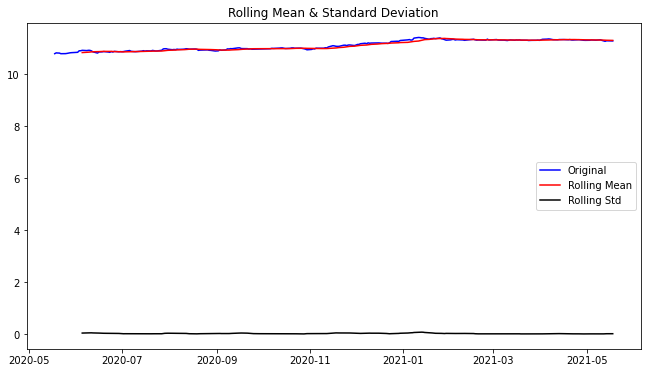

In [44]:
plot_rolling_statistics(samsung_ts_log, window=15)

### 3-2 ADF Testing

In [45]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [46]:
augmented_dickey_fuller_test(samsung_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 3-3 시계열 분해하기 Time Series DECOMPOSITION

In [47]:
def time_series_decomposition(ts_log):
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (11,6)
    
    plt.subplot(411)
    plt.plot(ts_log, label='original')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='seosonality')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='residual')
    plt.legend(loc='best')

    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


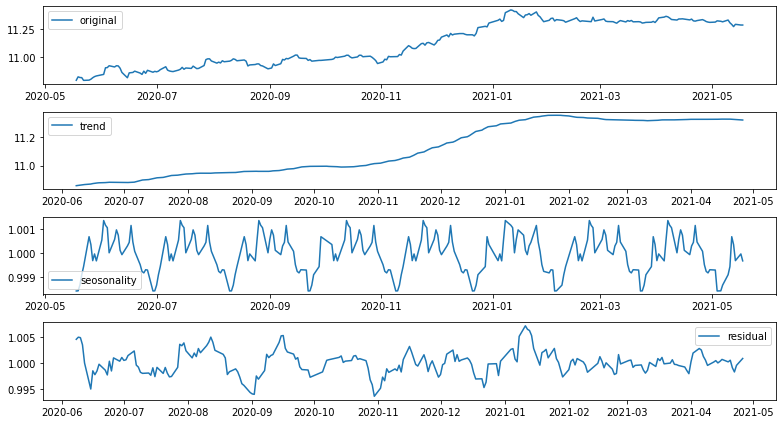

In [48]:
time_series_decomposition(samsung_ts_log)

## 4. Train, Test Dataset 만들기

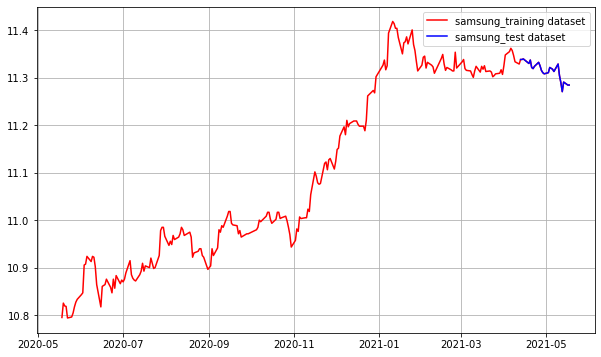

In [49]:
samsung_train_data, samsung_test_data = samsung_ts_log[:int(len(samsung_ts_log)*0.9)], samsung_ts_log[int(len(samsung_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(samsung_ts_log, c='r', label='samsung_training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(samsung_test_data, c='b', label='samsung_test dataset')
plt.legend()

## 5. 적정 ARIMA 찾기. 
### ~ q: ACF를 통해 MA모델의 시차 q를 결정한다
### ~ d: 차분 

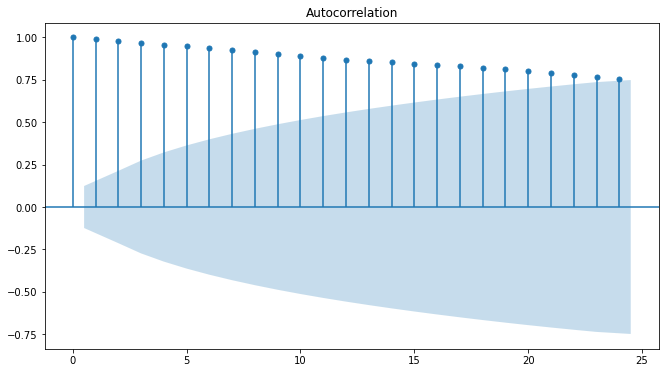

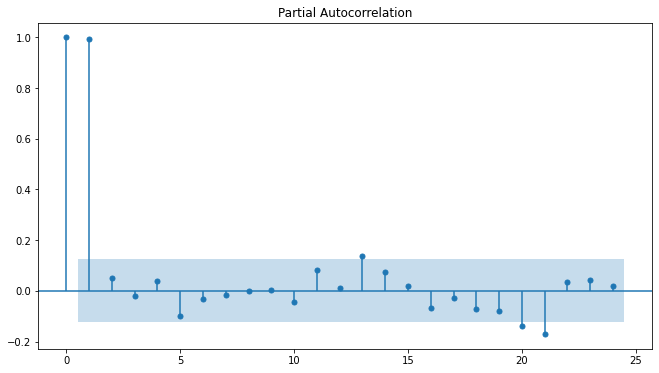

In [50]:
plot_acf(samsung_ts_log)
plot_pacf(samsung_ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


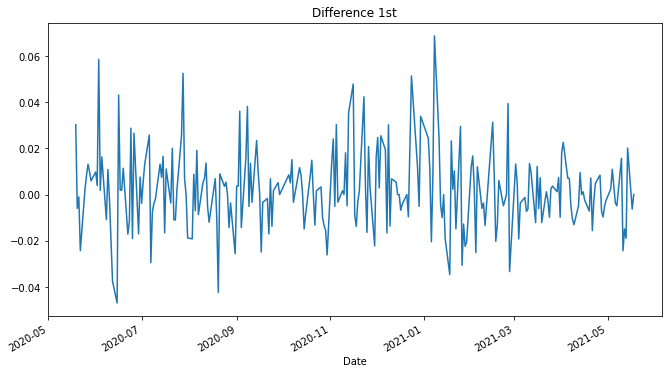

In [51]:
# 차분 안정성 확인 -> d구하기
samsung_diff_1 = samsung_ts_log.diff(periods=1).iloc[1:]
samsung_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(samsung_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


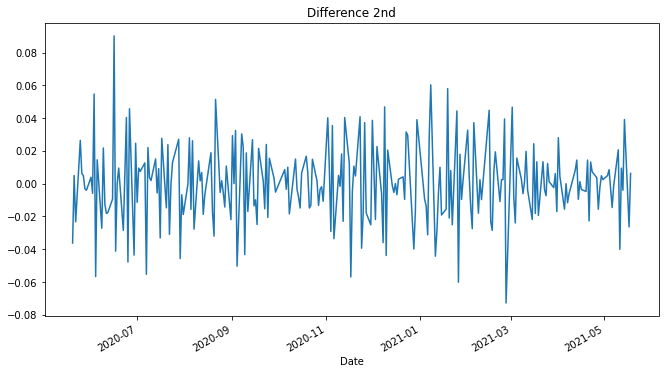

In [52]:
# 2차 차분 구하기
samsung_diff_2 = samsung_diff_1.diff(periods=1).iloc[1:]
samsung_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(samsung_diff_2)

## 6. ARIMA 모델 훈련과 테스트 하기  

In [53]:
def arima_test(train_data, test_data, order):
    # arima(data, order=c(p,d,q))
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1164.792
Time:                        00:16:46   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

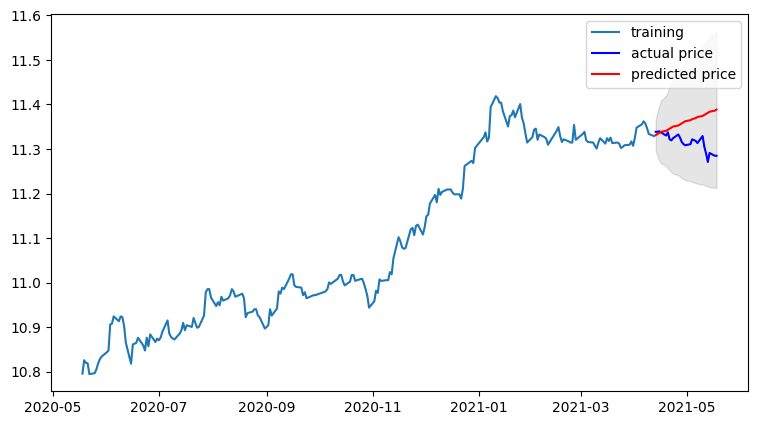

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


In [54]:
arima_test(samsung_train_data, samsung_test_data, (1, 1, 0))

## FOR DA METAVERSE (THE NEXT FUTURE) 
### 1. 시계열 데이터 준비

In [55]:
#META - Time Series 생성
Meta_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/Meta.csv'
Meta_df = pd.read_csv(Meta_dataset_filepath, index_col='Date', parse_dates=True)
Meta_ts = Meta_df['Close']
Meta_ts.head()

Date
2020-11-17    275.000000
2020-11-18    271.970001
2020-11-19    272.940002
2020-11-20    269.700012
2020-11-23    268.429993
Name: Close, dtype: float64

## 데이터 전처리 
### 2-1. 결측치 처리

In [56]:
print(Meta_ts[Meta_ts.isna()])
Meta_ts = Meta_ts.interpolate(method='time')
Meta_ts[Meta_ts.isna()]


Series([], Name: Close, dtype: float64)


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [57]:
Meta_ts_log = np.log(Meta_ts)

## 3. 시계열 안정성 분석

### 3-1. 정성적 그래프 분석


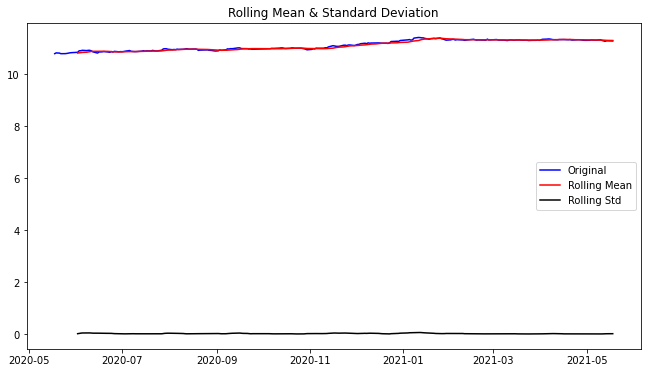

In [58]:
plot_rolling_statistics(samsung_ts_log, window=12)

### 3-2. ADF Test


In [59]:
augmented_dickey_fuller_test(Meta_ts_log)


Results of Dickey-Fuller Test:
Test Statistic                  -1.310478
p-value                          0.624365
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -6.530694e+00
p-value                        9.887104e-09
#Lags Used                     4.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


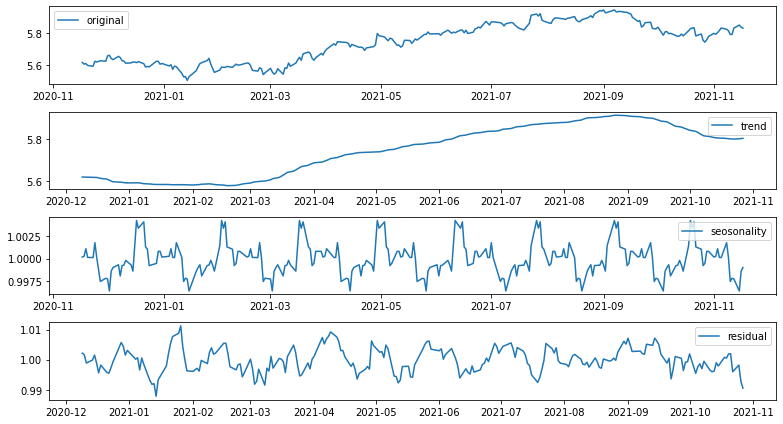

In [60]:
time_series_decomposition(Meta_ts_log)

## 4. train, test dataset 생성

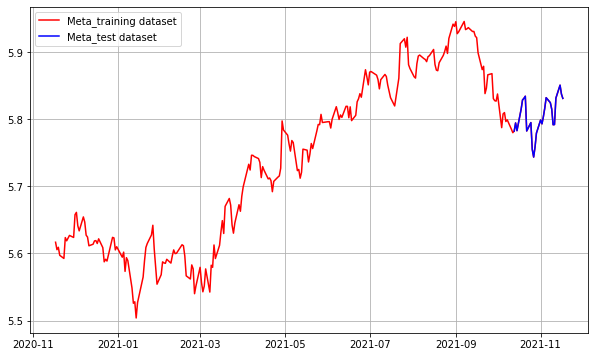

In [61]:
Meta_train_data, Meta_test_data = Meta_ts_log[:int(len(Meta_ts_log)*0.9)], Meta_ts_log[int(len(Meta_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(Meta_ts_log, c='r', label='Meta_training dataset')
plt.plot(Meta_test_data, c='b', label='Meta_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

###  q : ACF를 통해 MA모델의 시차 q를 결정 
### p : PACF를 통해 AR 모델의 시차 p를 결정
### d : 차분


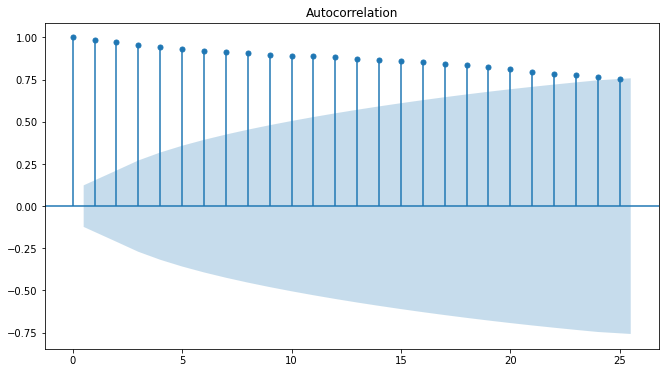

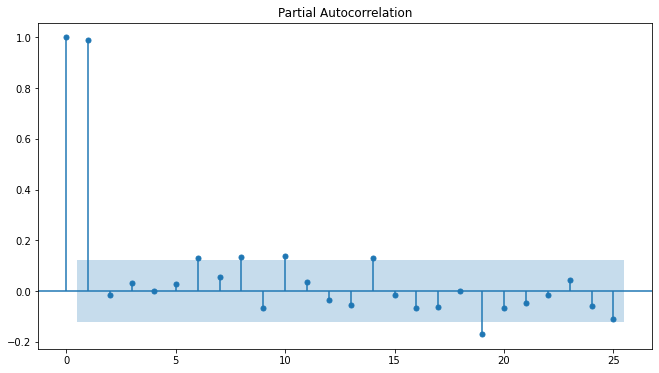

Results of Dickey-Fuller Test:
Test Statistic                -1.609863e+01
p-value                        5.160357e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


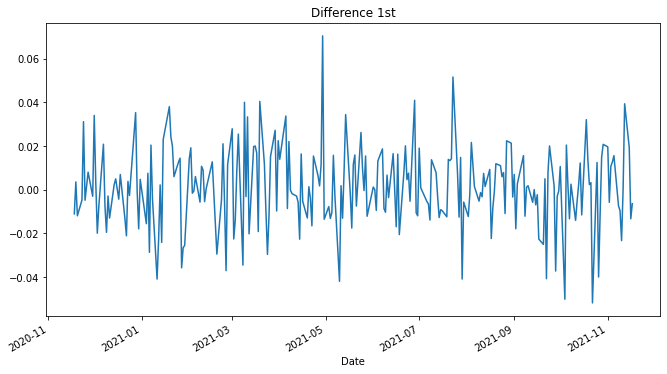

In [62]:
plot_acf(Meta_ts_log)
plot_pacf(Meta_ts_log)
plt.show()

# 차분 안정성 확인 -> d구하기
Meta_diff_1 = Meta_ts_log.diff(periods=1).iloc[1:]
Meta_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(Meta_diff_1)

## 6. ARIMA 모델 훈련과 테스트!!

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 590.925
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1175.850
Time:                        00:16:48   BIC                          -1165.588
Sample:                             1   HQIC                         -1171.708
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      0.633      0.526      -0.002       0.003
ar.L1.D.Close    -0.0299      0.066     -0.450      0.653      -0.160       0.100
                                    Root

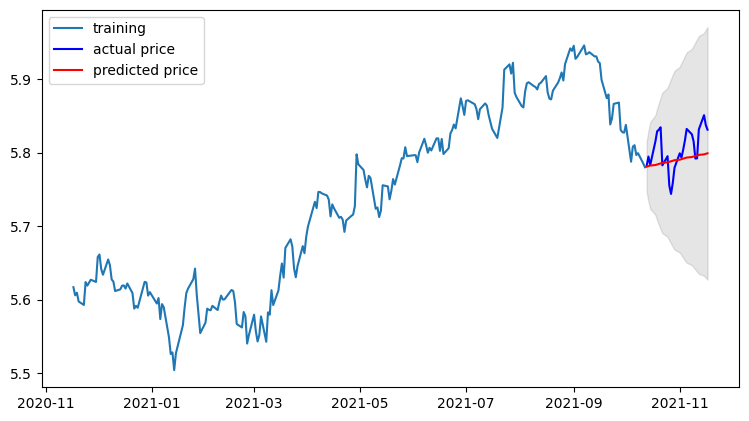

MSE:  94.46477883904996
MAE:  7.91580703785748
RMSE:  9.719299297740037
MAPE: 2.36%


In [63]:
arima_test(Meta_train_data, Meta_test_data, (1, 1, 0))